# Exploring Metrics for Business Popularity

In [1]:
import json
import pandas as pd
import numpy as np
import math
import datetime

### Reading the data

In [2]:
checkins_df = pd.read_json('./yelp/yelp_academic_dataset_checkin.json', lines=True)

In [3]:
checkins_df.head(2)

,business_id,date
0,--0r8K_AQ4FZfLsX3ZYRDA,2017-09-03 17:13:59
1,--0zrn43LEaB4jUWTQH_Bg,"2010-10-08 22:21:20, 2010-11-01 21:29:14, 2010..."


In [4]:
business_df = pd.read_json('./yelp/yelp_academic_dataset_business.json', lines=True)

In [5]:
business_df.head(2)

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,postal_code,review_count,stars,state
0,921 Pearl St,"{'RestaurantsTableService': 'True', 'WiFi': 'u...",6iYb2HFDywm3zjuRg0shjw,"Gastropubs, Food, Beer Gardens, Restaurants, B...",Boulder,"{'Monday': '11:0-23:0', 'Tuesday': '11:0-23:0'...",1,40.017544,-105.283348,Oskar Blues Taproom,80302,86,4.0,CO
1,7000 NE Airport Way,"{'RestaurantsTakeOut': 'True', 'RestaurantsAtt...",tCbdrRPZA0oiIYSmHG3J0w,"Salad, Soup, Sandwiches, Delis, Restaurants, C...",Portland,"{'Monday': '5:0-18:0', 'Tuesday': '5:0-17:0', ...",1,45.588906,-122.593331,Flying Elephants at PDX,97218,126,4.0,OR


In [6]:
print(f"There are {len(business_df)} businesses and {len(checkins_df)} businesses with check-ins")

There are 160585 businesses and 138876 businesses with check-ins


### Cleaning the data

In [7]:
business_df = business_df.drop(columns=['address', 'postal_code', 'state', 'name'])

In [8]:
business_df = business_df.dropna()

In [9]:
restaurants_df = business_df.loc[business_df["categories"].str.contains("Restaurants")]

In [10]:
print(f"There are {len(restaurants_df)} restaurants in the dataset")

There are 42646 restaurants in the dataset


In [11]:
restaurants_df.head(2)

,attributes,business_id,categories,city,hours,is_open,latitude,longitude,review_count,stars
0,"{'RestaurantsTableService': 'True', 'WiFi': 'u...",6iYb2HFDywm3zjuRg0shjw,"Gastropubs, Food, Beer Gardens, Restaurants, B...",Boulder,"{'Monday': '11:0-23:0', 'Tuesday': '11:0-23:0'...",1,40.017544,-105.283348,86,4.0
1,"{'RestaurantsTakeOut': 'True', 'RestaurantsAtt...",tCbdrRPZA0oiIYSmHG3J0w,"Salad, Soup, Sandwiches, Delis, Restaurants, C...",Portland,"{'Monday': '5:0-18:0', 'Tuesday': '5:0-17:0', ...",1,45.588906,-122.593331,126,4.0


### Processing the data

#### Frequency of Check-ins for a restaurant, adjusted for time
Date format: YYYY-MM-DD HH:MM:SS

Example: {"2010-10-08 22:21:20, 2010-11-01 21:29:14, 2010-12-23 22:55:45, 2011-04-08 17:14:59, 2011-04-11 21:28:45, 2011-04-26 16:42:25, 2011-05-20 19:30:57, 2011-05-24 20:02:21, 2011-08-29 19:01:31"}

In [12]:
def calculate_frequency(row):
    dates = row[1].split(",")
    count = len(dates)
    if count == 0 or count == 1:
        return 0
    
    first_date = datetime.datetime.strptime(dates[0].strip(), "%Y-%m-%d %H:%M:%S")
    last_date = datetime.datetime.strptime(dates[len(dates)-1].strip(), "%Y-%m-%d %H:%M:%S")
    time_period = last_date - first_date
    
    if time_period.days <= 5:
        return 0
    
    return round(count/time_period.days, 2)

In [13]:
checkins_freq_df = checkins_df[['business_id']].copy()
checkins_freq_df['frequency'] = checkins_df.apply(calculate_frequency, axis=1)
checkins_freq_df.head()

,business_id,frequency
0,--0r8K_AQ4FZfLsX3ZYRDA,0.00
1,--0zrn43LEaB4jUWTQH_Bg,0.03
2,--164t1nclzzmca7eDiJMw,0.23
3,--2aF9NhXnNVpDV0KS3xBQ,0.00
4,--2mEJ63SC_8_08_jGgVIg,0.00


In [14]:
restaurants_df = pd.merge(checkins_freq_df, restaurants_df, on='business_id')
restaurants_df.head(3)

,business_id,frequency,attributes,categories,city,hours,is_open,latitude,longitude,review_count,stars
0,--164t1nclzzmca7eDiJMw,0.23,"{'Alcohol': 'u'full_bar'', 'BusinessAcceptsCre...","Food, Ethnic Food, Nightlife, Restaurants, Div...",Austin,"{'Monday': '18:0-0:0', 'Tuesday': '11:30-0:0',...",0,30.264896,-97.731028,137,4.0
1,--6COJIAjkQwSUZci_4PJQ,0.10,"{'BusinessParking': '{'garage': False, 'street...","Breakfast & Brunch, Bakeries, Tea Rooms, Coffe...",Portland,"{'Monday': '0:0-0:0', 'Tuesday': '9:0-16:0', '...",0,45.467868,-122.714524,99,4.0
2,--UNNdnHRhsyFUbDgumdtQ,0.60,"{'RestaurantsPriceRange2': '3', 'BusinessParki...","French, Restaurants, American (New)",Portland,"{'Monday': '0:0-0:0', 'Tuesday': '17:0-22:0', ...",1,45.522796,-122.657872,1236,4.5


In [15]:
len(restaurants_df)

42089

#### Closed Restaurants

In [16]:
closed_restaurants_df = restaurants_df[restaurants_df["is_open"] == 0]

#### Rounding Up the Star Ratings

In [17]:
restaurants_df["rounded_stars"] = restaurants_df["stars"].apply(lambda x: math.ceil(x))

### Analyzing the data

#### How many restaurants are still open?

In [18]:
closed = len(closed_restaurants_df)
still_open = len(restaurants_df) - closed
print(f"{still_open} restaurants are still open, while {closed} ({round(closed/len(restaurants_df)*100, 2)}%) are closed.")

28428 restaurants are still open, while 13661 (32.46%) are closed.


#### How are the star ratings distributed for restaurants?

In [19]:
restaurants_df['stars'].value_counts()

4.0    11714
3.5    10651
3.0     6520
4.5     6233
2.5     3275
2.0     1808
5.0     1091
1.5      691
1.0      106
Name: stars, dtype: int64

In [20]:
star_avg = sum(restaurants_df['stars'])/len(restaurants_df['stars'])
print(f"Average star rating is {round(star_avg, 2)} for all restaurants")

Average star rating is 3.57 for all restaurants


#### Is there a correlation between frequency and review count?

In [21]:
restaurants_df[['review_count', 'frequency']].corr()

,review_count,frequency
review_count,1.000000,0.759045
frequency,0.759045,1.000000


#### Is there a correlation between frequency and star rating?

In [22]:
restaurants_df[['frequency', 'stars']].corr()

,frequency,stars
frequency,1.000000,0.173341
stars,0.173341,1.000000


In [23]:
restaurants_df[['frequency', 'rounded_stars']].corr()

,frequency,rounded_stars
frequency,1.000000,0.158649
rounded_stars,0.158649,1.000000


#### Is there a correlation between star rating and review count?

In [24]:
restaurants_df[['review_count', 'stars']].corr()

,review_count,stars
review_count,1.000000,0.145757
stars,0.145757,1.000000


In [25]:
restaurants_df[['review_count', 'rounded_stars']].corr()

,review_count,rounded_stars
review_count,1.000000,0.133541
rounded_stars,0.133541,1.000000


#### Plotting the star ratings and frequency

In [26]:
restaurants_df.plot(x='frequency', y='stars', style='o')

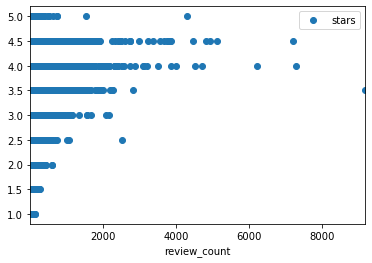

In [27]:
restaurants_df.plot(x='review_count', y='stars', style='o')

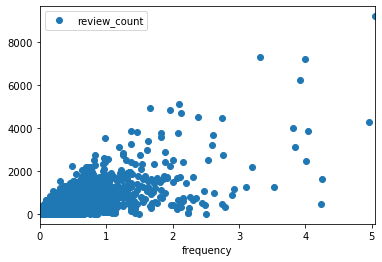

In [28]:
restaurants_df.plot(x='frequency', y='review_count', style='o')

#### Average Frequency for each Star Rating

In [29]:
restaurants_df.groupby("stars")["frequency"].mean()

stars
1.0    0.009151
1.5    0.016802
2.0    0.030122
2.5    0.050260
3.0    0.076656
3.5    0.114924
4.0    0.154327
4.5    0.137322
5.0    0.063868
Name: frequency, dtype: float64

In [38]:
avg_freq_stars = restaurants_df.groupby("rounded_stars")["frequency"].mean()

In [39]:
avg_freq_stars

rounded_stars
1    0.009151
2    0.026439
3    0.067831
4    0.135562
5    0.126380
Name: frequency, dtype: float64

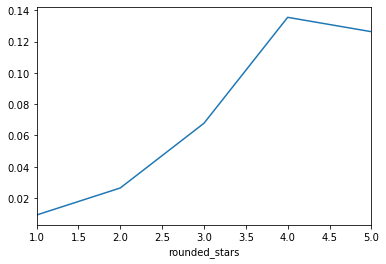

In [40]:
avg_freq_stars.plot()

#### Average Count Review for each Star Rating

In [46]:
avg_freq_reviews = restaurants_df.groupby("rounded_stars")["review_count"].mean()

In [47]:
avg_freq_reviews

rounded_stars
1     18.990566
2     35.606242
3     74.747014
4    151.403845
5    130.153332
Name: review_count, dtype: float64

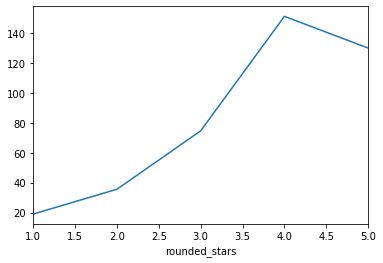

In [48]:
avg_freq_reviews.plot()